# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [17]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [18]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [19]:
system_message = "You are a helpful assistant for an restaurant locator app called FoodAI. "
system_message += "Give short, friendly suggestions. "
system_message += "Use Map be with 5 miles of a location. If you don't know the answer, be honest."

In [27]:
# Let's start by making a useful function

restaurants_inventory = {"antioch": ["Indian Tandoor","clay Oven"], "brentwood": ["chutney","faz"], "concord": ["Thai Basil","Olive Garden"]}

def restaurants_by_city(search_city):
    print(f"Tool restaurants_by_city called for {search_city}")
    city = search_city.lower()
    
    return restaurants_inventory.get(city, "Unknown")

In [28]:
restaurants_by_city("antioch")

Tool restaurants_by_city called for antioch


['Indian Tandoor', 'clay Oven']

In [29]:
# There's a particular dictionary structure that's required to describe our function:

restaurant_locator_function = {
    "name": "restaurants_by_city",
    "description": "Get the names of a restaurant of a given city, for example when a customer asks 'What are the most popular restaurants is for this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "search_city": {
                "type": "string",
                "description": "The city where customer wants to find a good restaurants",
            },
        },
        "required": ["search_city"],
        "additionalProperties": False
    }
}

In [30]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": restaurant_locator_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [31]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [32]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('search_city')
    names = restaurants_by_city(city)
    response = {
        "role": "tool",
        "content": json.dumps({"search_city": city,"names": names}),
        "tool_call_id": tool_call.id
    }
    return response, city

Tool restaurants_by_city called for Concord


In [26]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7875
* To create a public link, set `share=True` in `launch()`.


Tool restaurants_by_city called for Concord


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [36]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [37]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a restaurant in {city}, showing food joints and everything unique about {city}, in a vibrant downtown style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

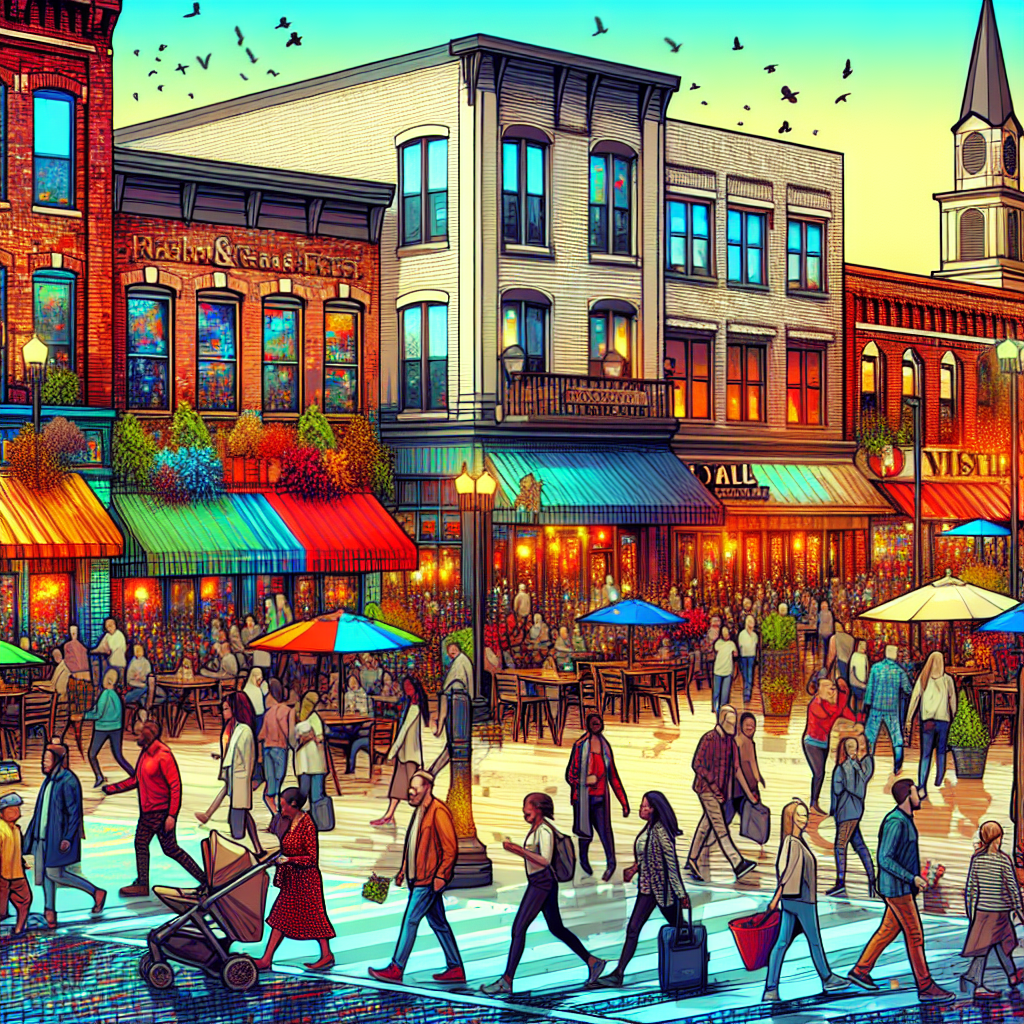

In [38]:
image = artist("Concord")
display(image)

## To check you now have ffmpeg and can access it here

Excecute the next cell to see if you get a version number. (Putting an exclamation mark before something in Jupyter Lab tells it to run it as a terminal command rather than python code).

If this doesn't work, you may need to actually save and close down your Jupyter lab, and start it again from a new Terminal window (Mac) or Anaconda prompt (PC), remembering to activate the llms environment. This ensures you pick up ffmpeg.

And if that doesn't work, please contact me!

In [39]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [43]:
!pip install simpleaudio

In [45]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [46]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.


Tool restaurants_by_city called for Concord


# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>